In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device = {device}')

device = cuda:0


In [3]:

class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers=2, neurons=50):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
model = FCN(in_dim = 2, out_dim = 1).to(device)


In [5]:
# Generate Collocation Points

N_f = 1000
x_f = torch.rand(N_f,1)
t_f = torch.rand(N_f,1)
X_f = torch.cat([x_f,t_f], dim = 1).to(device).requires_grad_(True)

# Generate BC Points
N_b = 100
x_lb = torch.zeros(N_b,1)
x_rb = torch.ones(N_b,1)
t_b = torch.linspace(0,1,N_b).view(-1,1)

X_lb = torch.cat([x_lb, t_b], dim = 1).to(device)
X_rb = torch.cat([x_rb,t_b], dim = 1).to(device)

# Generate IC Points
N_i = 100
x_i = torch.linspace(0,1,N_i).view(-1,1)
t_i = torch.zeros(N_i,1)

X_i = torch.cat([x_i, t_i], dim = 1).to(device)

u_i = torch.sin(np.pi * X_i[0])



In [6]:
def compute_residuals(model,alpha):
    u_f_pred = model(X_f)
    u_t = autograd.grad(u_f_pred,X_f,grad_outputs=torch.ones_like(u_f_pred), create_graph=True)[0][:,1:2]
    u_x = autograd.grad(u_f_pred,X_f,grad_outputs=torch.ones_like(u_f_pred), create_graph=True)[0][:,0:1]
    u_x_x = autograd.grad(u_x,X_f,grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:,0:1]

    res_pde = u_t - alpha * u_x_x

    u_l_bc = model(X_lb)
    u_r_bc = model(X_rb)

    res_bc = torch.cat([u_l_bc, u_r_bc], dim = 0)

    u_i_pred = model(X_i)

    res_ic = u_i_pred - u_i

    return res_pde, res_bc, res_ic

In [7]:
sigma = 0.01
def log_likelihood(model, alpha):
    res_pde, res_bc, res_ic = compute_residuals(model, alpha)
    loss = torch.mean(res_pde ** 2) + torch.mean(res_bc ** 2) + torch.mean(res_ic ** 2)
    return -loss / (2 * sigma**2)

In [8]:
def log_prior(alpha):
    return torch.distributions.LogNormal(0.0,1.0).log_prob(alpha)


In [9]:
def pretrain_model(model):
    epochs = 10000

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    for epoch in range(epochs):
        res_pde, res_bc,res_ic = compute_residuals(model, alpha = torch.tensor([1.0], device = device))
        loss = torch.mean(res_pde ** 2) + torch.mean(res_bc ** 2) + torch.mean(res_ic ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")



pretrain_model(model)

/home/soumik/miniconda3/envs/pyro_env/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Loss = 0.026487
Epoch 1000: Loss = 0.000001
Epoch 2000: Loss = 0.000000
Epoch 3000: Loss = 0.000000
Epoch 4000: Loss = 0.000000
Epoch 5000: Loss = 0.000000
Epoch 6000: Loss = 0.000000
Epoch 7000: Loss = 0.000015
Epoch 8000: Loss = 0.000000
Epoch 9000: Loss = 0.000000


In [10]:
def mcmc(model):
    n_samples = 1000
    samples = []

    alpha = torch.tensor([0.5], requires_grad=False, device = device)
    
    current_log_posterior = log_likelihood(model,alpha) + log_prior(alpha)

    for i in range(n_samples):
        proposal = alpha + 0.05 * torch.randn_like(alpha).to(device)
        if proposal <= 0:
            samples.append(alpha.item())
            continue
        log_posterior = log_likelihood(model,proposal) + log_prior(proposal)
        log_r = log_posterior - current_log_posterior

        if torch.log(torch.rand(1).to(device)) < log_r:
            alpha = proposal
            current_log_posterior = log_posterior
        samples.append(alpha.item())

    return samples

In [11]:

samples = mcmc(model)
print(samples)

[0.5097009539604187, 0.516657829284668, 0.49072039127349854, 0.45585209131240845, 0.3924410045146942, 0.4656388461589813, 0.37941974401474, 0.4185265302658081, 0.45951616764068604, 0.508847177028656, 0.4600752592086792, 0.4889143407344818, 0.5504112839698792, 0.5645053386688232, 0.4830498993396759, 0.5151734352111816, 0.5337738394737244, 0.5544529557228088, 0.5351478457450867, 0.5980125665664673, 0.5651696920394897, 0.5979976058006287, 0.582459568977356, 0.5337211489677429, 0.450642853975296, 0.4724257290363312, 0.48019206523895264, 0.5088602900505066, 0.44863778352737427, 0.4360182285308838, 0.40857210755348206, 0.4422172009944916, 0.4902220368385315, 0.4950360357761383, 0.5101302266120911, 0.5175102353096008, 0.5542526841163635, 0.48982566595077515, 0.44765785336494446, 0.45145130157470703, 0.3660057783126831, 0.2633790969848633, 0.17267057299613953, 0.16112764179706573, 0.12428894639015198, 0.12428894639015198, 0.19035926461219788, 0.23439347743988037, 0.229338601231575, 0.262518018

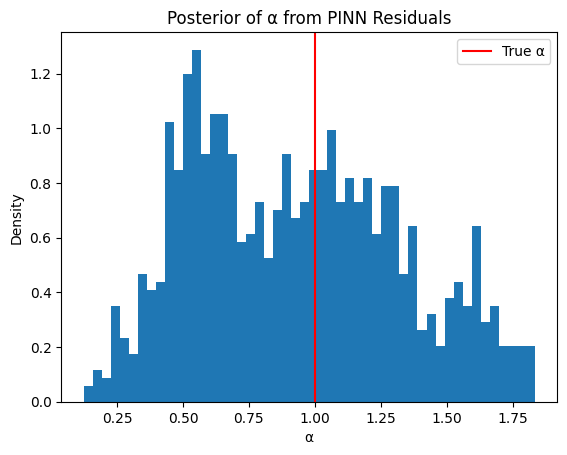

In [12]:
plt.hist(samples, bins=50, density=True)
plt.axvline(1.0, color='r', label='True α')
plt.title("Posterior of α from PINN Residuals")
plt.xlabel("α")
plt.ylabel("Density")
plt.legend()
plt.show()


In [13]:
# Observations

x_obs = torch.rand(20,1)
t_obs = torch.rand(20,1)

X_obs = torch.cat([x_obs,t_obs], dim = 1).to(device)

u_obs = torch.sin(np.pi * X_obs[0]) * torch.exp(-np.pi ** 2 * X_obs[1])

In [14]:
def data_log_likelihood(model, alpha):
    u_pred = model(X_obs)

    data_loss = torch.mean((u_pred - u_obs) ** 2)

    return -data_loss / (2* sigma**2)

In [15]:
def mcmc_update(model, prior_samples):
    n_samples = 1000
    updated_samples = []

    alpha = torch.tensor([prior_samples[len(prior_samples) // 2]], device = device)

    updated_current_log_posterior = data_log_likelihood(model, alpha) + log_prior(alpha)

    for i in range(n_samples):
        proposal = alpha + 0.05 * torch.randn_like(alpha).to(device)
        if proposal <= 0:
            updated_samples.append(alpha.item())
            continue
        updated_log_posterior = data_log_likelihood(model,proposal) + log_prior(proposal)
        log_r = updated_log_posterior - updated_current_log_posterior

        if torch.log(torch.rand(1).to(device)) < log_r:
            alpha = proposal
            updated_current_log_posterior = updated_log_posterior
        updated_samples.append(alpha.item())

    return updated_samples

In [16]:
updated_samples = mcmc_update(model,samples)
print(updated_samples)

[1.5240534543991089, 1.4726661443710327, 1.5728199481964111, 1.5742384195327759, 1.6495388746261597, 1.6946889162063599, 1.757323980331421, 1.7503217458724976, 1.8238357305526733, 1.860580563545227, 1.918427586555481, 1.9348416328430176, 1.9054456949234009, 1.8050482273101807, 1.7936798334121704, 1.746437907218933, 1.7306139469146729, 1.8066579103469849, 1.8113983869552612, 1.8646708726882935, 2.0301151275634766, 1.9601140022277832, 1.9571759700775146, 1.9571759700775146, 1.8984081745147705, 1.9105746746063232, 1.9371936321258545, 1.8841900825500488, 1.8464833498001099, 1.8352023363113403, 1.7871516942977905, 1.7869454622268677, 1.7309179306030273, 1.7177199125289917, 1.6487534046173096, 1.714697241783142, 1.7232601642608643, 1.7105271816253662, 1.7064483165740967, 1.7072964906692505, 1.6801807880401611, 1.6831406354904175, 1.693098545074463, 1.6726595163345337, 1.6578094959259033, 1.7050625085830688, 1.7191356420516968, 1.7149001359939575, 1.7289329767227173, 1.7561875581741333, 1.764

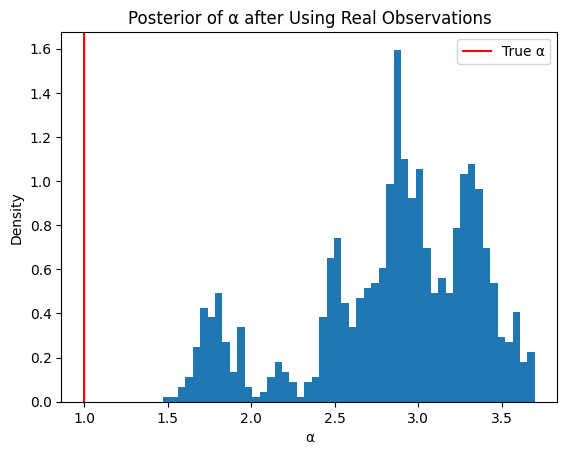

In [17]:
plt.hist(updated_samples, bins=50, density=True)
plt.axvline(1.0, color='r', label='True α')
plt.title("Posterior of α after Using Real Observations")
plt.xlabel("α")
plt.ylabel("Density")
plt.legend()
plt.show()

In [18]:
# Predictive distribution of u at fixed t = 0.5

x_predictive = torch.linspace(0,1,100).view(-1,1)
t_predictive =  torch.full_like(x_predictive, 0.5)

X_pred = torch.cat([x_predictive, t_predictive], dim = 1).to(device)

with torch.no_grad():
    u_preds = []

    for alpha_value in updated_samples[::10]:
        u = model(X_pred).cpu().numpy()
        u_preds.append(u.squeeze())

    u_preds = np.array(u_preds)

mean_pred = u_preds.mean(axis=0)
std_pred = u_preds.std(axis=0)

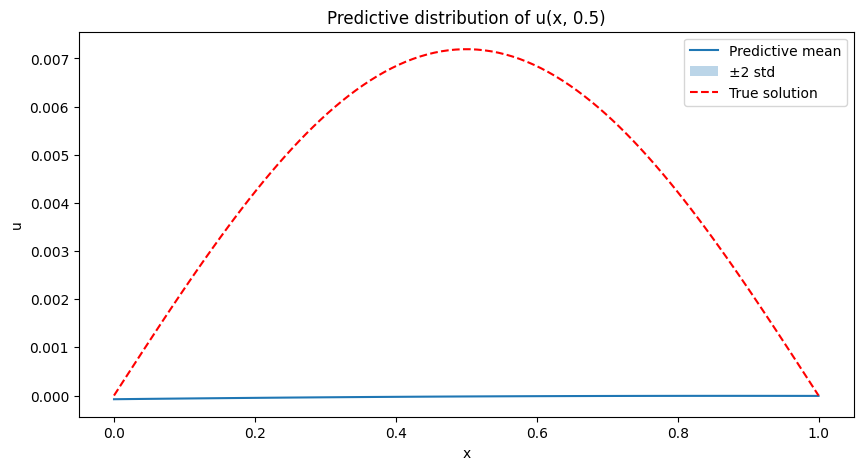

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(x_predictive.cpu().numpy(), mean_pred, label="Predictive mean")
plt.fill_between(x_predictive.cpu().numpy().squeeze(),
                 mean_pred - 2 * std_pred,
                 mean_pred + 2 * std_pred,
                 alpha=0.3, label="±2 std")
plt.plot(x_predictive.cpu().numpy(),
         (torch.sin(np.pi * x_predictive) * torch.exp(-np.pi**2 * t_predictive)).cpu().numpy(),
         'r--', label="True solution")
plt.title("Predictive distribution of u(x, 0.5)")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()